# Practice Session 05: Outlier analysis

Author: <font color="blue">Marc Pérez Pratdesaba</font>

E-mail: <font color="blue">marc.perez12@estudiant.upf.edu</font>

Date: <font color="blue">03/12/2022</font>

The objective is to practice finding outliers by implementing the [Isolation Forest](https://en.wikipedia.org/wiki/Isolation_forest) algorithm.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import io
import random
import numpy as np

# 1. Dataset

In [6]:
df = pd.read_csv('annthyroid.csv', sep=',')

# Replace the "label" column by an "abnormal" column
df['result'] = df['label'].apply(lambda x: 'abnormal' if x == 1 else 'normal')
df.drop(columns=['label'], inplace=True)

In [7]:
display(df.head(5))

,f1,f2,f3,f4,f5,f6,result
0,0.73,0.00060,0.015,0.120,0.082,0.146,normal
1,0.24,0.00025,0.030,0.143,0.133,0.108,normal
2,0.47,0.00190,0.024,0.102,0.131,0.078,normal
3,0.64,0.00090,0.017,0.077,0.090,0.085,normal
4,0.23,0.00025,0.026,0.139,0.090,0.153,normal


In [8]:
#Show percentages of normal and abnormal patients

num_patients = df.shape[0]

normal_thy_patients = len(df[df["result"] == "normal"])
normal_thy_patients_percentage = round(normal_thy_patients/num_patients, 3)

abnormal_thy_patients = len(df[df["result"] != "normal"])
abnormal_thy_patients_percentage = round(abnormal_thy_patients/num_patients, 3)
print(f"Normal patients: {normal_thy_patients} --- Percentage: {round(normal_thy_patients_percentage*100, 3)} %\n")
print(f"Abnormal patients: {abnormal_thy_patients} --- Percentage: {round(abnormal_thy_patients_percentage*100, 3)} %\n")

Normal patients: 6666 --- Percentage: 92.6 %

Abnormal patients: 534 --- Percentage: 7.4 %



In [9]:
# Creating new dataframes for normal and abnormal patients, and show the means of the features for each case

normal_df = df[df["result"] == "normal"]
display(normal_df.head(10))
mean_normal_df = df[df["result"] == "normal"].mean()
print(mean_normal_df)

abnormal_df = df[df["result"] != "normal"]
display(abnormal_df.head(10))
mean_abnormal_df = df[df["result"] != "normal"].mean()
print(mean_abnormal_df)

,f1,f2,f3,f4,f5,f6,result
0,0.73,0.00060,0.015,0.120,0.082,0.146,normal
1,0.24,0.00025,0.030,0.143,0.133,0.108,normal
2,0.47,0.00190,0.024,0.102,0.131,0.078,normal
3,0.64,0.00090,0.017,0.077,0.090,0.085,normal
4,0.23,0.00025,0.026,0.139,0.090,0.153,normal
5,0.69,0.00025,0.016,0.086,0.070,0.123,normal
6,0.85,0.00025,0.023,0.128,0.104,0.121,normal
7,0.48,0.00208,0.020,0.086,0.078,0.110,normal
8,0.67,0.00130,0.024,0.087,0.109,0.080,normal
9,0.76,0.00010,0.029,0.124,0.128,0.097,normal


f1    0.518314
f2    0.002098
f3    0.020384
f4    0.112193
f5    0.097705
f6    0.116132
dtype: float64


,f1,f2,f3,f4,f5,f6,result
10,0.62,0.01100,0.0080,0.0730,0.074,0.0980,abnormal
19,0.50,0.06100,0.0096,0.0130,0.116,0.0110,abnormal
27,0.78,0.02500,0.0090,0.0500,0.084,0.0600,abnormal
43,0.61,0.00979,0.0040,0.0810,0.064,0.1260,abnormal
84,0.56,0.00820,0.0200,0.0660,0.094,0.0700,abnormal
105,0.73,0.04700,0.0110,0.0520,0.090,0.0580,abnormal
115,0.43,0.07000,0.0050,0.0029,0.104,0.0028,abnormal
116,0.42,0.03100,0.0080,0.0130,0.119,0.0110,abnormal
145,0.78,0.00630,0.0110,0.0560,0.086,0.0650,abnormal
147,0.53,0.02500,0.0040,0.0390,0.061,0.0640,abnormal


f1    0.548034
f2    0.039363
f3    0.014891
f4    0.074940
f5    0.099500
f6    0.076803
dtype: float64


The features that we will consider useful are the ones for which the means differ significantly between normal and abnormal. That is, if some feature (for instance f1) has a mean of 0.518 in normal, and 0.548 for abnormal, this difference between the means is what we will use to distinguish if the thyroid is normal or abnormal. In the following code we can see the differences between the features:

In [39]:
print(mean_normal_df - mean_abnormal_df)

f1   -0.029720
f2   -0.037265
f3    0.005493
f4    0.037253
f5   -0.001795
f6    0.039328
dtype: float64


Therefore, as **f1, f2, f4, and f6** are the ones with the largest differences, we will take them as the useful ones to differentiating between normal and abnormal.

array([[<AxesSubplot:xlabel='f1', ylabel='f1'>,
        <AxesSubplot:xlabel='f2', ylabel='f1'>,
        <AxesSubplot:xlabel='f3', ylabel='f1'>,
        <AxesSubplot:xlabel='f4', ylabel='f1'>,
        <AxesSubplot:xlabel='f5', ylabel='f1'>,
        <AxesSubplot:xlabel='f6', ylabel='f1'>],
       [<AxesSubplot:xlabel='f1', ylabel='f2'>,
        <AxesSubplot:xlabel='f2', ylabel='f2'>,
        <AxesSubplot:xlabel='f3', ylabel='f2'>,
        <AxesSubplot:xlabel='f4', ylabel='f2'>,
        <AxesSubplot:xlabel='f5', ylabel='f2'>,
        <AxesSubplot:xlabel='f6', ylabel='f2'>],
       [<AxesSubplot:xlabel='f1', ylabel='f3'>,
        <AxesSubplot:xlabel='f2', ylabel='f3'>,
        <AxesSubplot:xlabel='f3', ylabel='f3'>,
        <AxesSubplot:xlabel='f4', ylabel='f3'>,
        <AxesSubplot:xlabel='f5', ylabel='f3'>,
        <AxesSubplot:xlabel='f6', ylabel='f3'>],
       [<AxesSubplot:xlabel='f1', ylabel='f4'>,
        <AxesSubplot:xlabel='f2', ylabel='f4'>,
        <AxesSubplot:xlabel='f3', yla

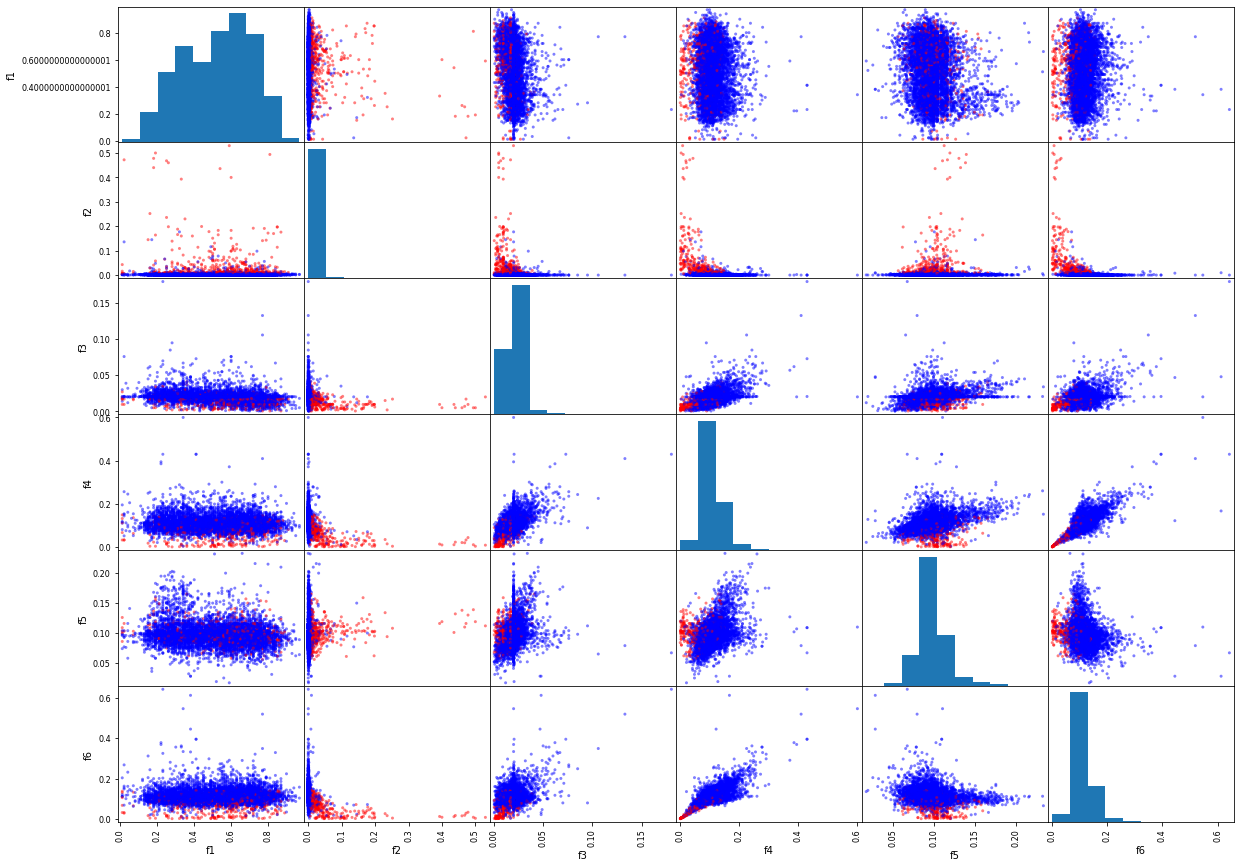

In [11]:
color_code = {'abnormal': "Red", 'normal': "Blue"}

colors = df['result'].apply(lambda x: color_code[x])

#Scatter matrix
pd.plotting.scatter_matrix(df, c=colors, figsize = (20, 15))

From these combinations of features plots, we can already see that for some features, the thyroids can be relatively differentiated. For instance, with feature 2 we can observe that the red points (abnormal) have a tendency to have a higher value than the blue points (normal). These differences can also be observed for feature 6, where the cluster of red points lie in closer values to 0.0 whereas the blue ones are greater.

# 1. Create isolation tree

## 1.1. Random dimension and random split

In [41]:
def pick_random_dimension(df, columns_to_ignore):
    df_rel = df.drop(columns = columns_to_ignore)
    rand_dim = random.choice(df_rel.columns)
    return rand_dim


columns_to_ignore = ["result"]
random_dim_1 = pick_random_dimension(df, columns_to_ignore);
random_dim_2 = pick_random_dimension(df, columns_to_ignore);
print(f"Random dimension 1: {random_dim_1}")
print(f"Random dimension 2: {random_dim_2}")


Random dimension 1: f1
Random dimension 2: f3


In [43]:
def pick_random_split(df, dimension):
    rand_range = random.uniform(np.min(df[dimension]), np.max(df[dimension]))
    return rand_range

dimension = pick_random_dimension(df, columns_to_ignore)
rand_split_1 = pick_random_split(df, dimension)
rand_split_2 = pick_random_split(df, dimension)

print(f"Random split 1: {rand_split_1}")
print(f"Random split 2: {rand_split_2}")

Random split 1: 0.3085228642344989
Random split 2: 0.5474845971773478


## 1.2. Implement split data into two

In [14]:
def split_dataset(df, dimension, split):
    df_dim_left = df[df[dimension] <= split]
    df_dim_right = df[df[dimension] > split]
    
    return df_dim_left, df_dim_right

In [15]:
(left, right) = split_dataset(df, 'f1', 0.4)
print("SPLIT 1:")
display(left)
print("SPLIT 2:")
display(right)

if left.shape[0] + right.shape[0] == df.shape[0]:
    print("\nCorrect split")
else:
    print("\nIncorrect split")

SPLIT 1:


,f1,f2,f3,f4,f5,f6,result
1,0.24,0.00025,0.0300,0.143,0.133,0.108,normal
4,0.23,0.00025,0.0260,0.139,0.090,0.153,normal
11,0.18,0.00010,0.0230,0.098,0.085,0.115,normal
15,0.39,0.00010,0.0180,0.090,0.071,0.126,normal
16,0.39,0.00060,0.0200,0.114,0.100,0.114,normal
...,...,...,...,...,...,...,...
7166,0.36,0.00097,0.0201,0.101,0.077,0.131,normal
7167,0.36,0.00340,0.0469,0.172,0.087,0.198,normal
7179,0.33,0.00230,0.0201,0.077,0.083,0.093,normal
7180,0.30,0.00170,0.0230,0.083,0.081,0.102,normal


SPLIT 2:


,f1,f2,f3,f4,f5,f6,result
0,0.73,0.00060,0.0150,0.120,0.082,0.1460,normal
2,0.47,0.00190,0.0240,0.102,0.131,0.0780,normal
3,0.64,0.00090,0.0170,0.077,0.090,0.0850,normal
5,0.69,0.00025,0.0160,0.086,0.070,0.1230,normal
6,0.85,0.00025,0.0230,0.128,0.104,0.1210,normal
...,...,...,...,...,...,...,...
7194,0.79,0.00490,0.0201,0.077,0.082,0.0940,normal
7195,0.59,0.00250,0.0208,0.079,0.099,0.0800,normal
7196,0.51,0.10600,0.0060,0.005,0.089,0.0055,abnormal
7197,0.51,0.00076,0.0201,0.090,0.067,0.1340,normal



Correct split


## 1.3. Create one isolation tree

In [16]:
#Creating ID's
dfi = df.copy()
dfi.insert(0, 'id', [("P%.4d" % x) for x in range(1, 1 + len(df))])
dfi

,id,f1,f2,f3,f4,f5,f6,result
0,P0001,0.73,0.00060,0.0150,0.120,0.082,0.1460,normal
1,P0002,0.24,0.00025,0.0300,0.143,0.133,0.1080,normal
2,P0003,0.47,0.00190,0.0240,0.102,0.131,0.0780,normal
3,P0004,0.64,0.00090,0.0170,0.077,0.090,0.0850,normal
4,P0005,0.23,0.00025,0.0260,0.139,0.090,0.1530,normal
...,...,...,...,...,...,...,...,...
7195,P7196,0.59,0.00250,0.0208,0.079,0.099,0.0800,normal
7196,P7197,0.51,0.10600,0.0060,0.005,0.089,0.0055,abnormal
7197,P7198,0.51,0.00076,0.0201,0.090,0.067,0.1340,normal
7198,P7199,0.35,0.00280,0.0201,0.090,0.089,0.1010,normal


In [17]:
def isolation_tree(data, columns_to_ignore, min_items):
    tree = {}
    if len(data) <= min_items:
        return {"contents": data}
    else:
        rand_dim = pick_random_dimension(data, columns_to_ignore) # Pick random dimensions
        rand_split = pick_random_split(data, rand_dim) # Pick random split
        (left, right) = split_dataset(data, rand_dim, rand_split) # Split the dataset
        tree = {"left": isolation_tree(left, columns_to_ignore, min_items), "right": isolation_tree(right, columns_to_ignore, min_items), "dimension": rand_dim, "split": rand_split} # Recursive call
        return tree 

In [18]:
min_items_mytree = 500
mytree = isolation_tree(dfi, ['id', 'result'], min_items_mytree)

In [19]:
class tree_drawing(object):
    def __init__(self, value, left=None, right=None):
        self.value = value
        self.left = left
        self.right = right

    def __str__(self, label='', level=0):
        ret = "-" * level + label + ":" + repr(self.value)+"\n"
        if self.left:
            ret += self.left.__str__("<", level+1)
        if self.right:
            ret += self.right.__str__(">", level+1)
        return ret

    def __repr__(self):
        return self.value
    
def tree_to_nodes(tree):
    if 'contents' in tree:
        data = tree['contents']
        normal_count = len(data[data['result'] == 'normal'])
        abnormal_count = len(data[data['result'] == 'abnormal'])
        description = "external node: %d normal + %d abnormal" % (normal_count, abnormal_count)
        return tree_drawing(description)
    else:
        left = tree['left']
        right = tree['right']
        description = 'internal node: ' + tree['dimension'] + ' <= ' + ("%.2f" % tree['split'])
        n = tree_drawing(description, tree_to_nodes(left), tree_to_nodes(right) )
        return n

In [20]:
print(tree_to_nodes(mytree))

:'internal node: f5 <= 0.22'
-<:'internal node: f1 <= 0.43'
--<:'internal node: f5 <= 0.17'
---<:'internal node: f5 <= 0.03'
----<:'external node: 2 normal + 0 abnormal'
---->:'internal node: f4 <= 0.04'
-----<:'external node: 19 normal + 31 abnormal'
----->:'internal node: f3 <= 0.08'
------<:'internal node: f3 <= 0.04'
-------<:'internal node: f6 <= 0.46'
--------<:'internal node: f2 <= 0.16'
---------<:'internal node: f3 <= 0.00'
----------<:'external node: 4 normal + 0 abnormal'
---------->:'internal node: f4 <= 0.35'
-----------<:'internal node: f5 <= 0.12'
------------<:'internal node: f5 <= 0.11'
-------------<:'internal node: f2 <= 0.12'
--------------<:'internal node: f2 <= 0.06'
---------------<:'internal node: f5 <= 0.10'
----------------<:'internal node: f3 <= 0.03'
-----------------<:'internal node: f6 <= 0.19'
------------------<:'internal node: f6 <= 0.14'
-------------------<:'internal node: f2 <= 0.05'
--------------------<:'internal node: f3 <= 0.02'
-----------------

In [21]:
def get_max_tree_depth(tree):
    if ('left' not in tree.keys() or 'right' not in tree.keys()): # If we don't find 'left' or 'right' in tree, we are in leaf node
        return 1
    else:
        return max(get_max_tree_depth(tree['left']), get_max_tree_depth(tree['right'])) + 1 # If not, we do recursive call and get the max out of 'left' and 'right' + 1

In [22]:
max_depth_mytree = get_max_tree_depth(mytree)
print(f"The maximum depth of mytree is: {max_depth_mytree}")

The maximum depth of mytree is: 31


# 2. Create isolation forests and find depth of items

## 2.1. Create an isolation forest

In [23]:
def isolation_forest(dfi, columns_to_ignore, min_items, num_trees):
    forest_res = []*num_trees # Create array of trees -> Forest
    for i in range(num_trees):
        forest_res.append(isolation_tree(dfi, columns_to_ignore, min_items)) # For every tree in num_trees, we append isolation_tree
        
    return forest_res

In [24]:
# These values can be modified

min_items = 100
num_trees = 30

In [25]:
myforest = isolation_forest(dfi, ['id', 'result'], min_items, num_trees)
print("The forest has %d trees" % len(myforest))

The forest has 30 trees


In [26]:
for i in range(0, 3):
    print("Tree number %d" % i)
    print(tree_to_nodes(myforest[i]))
    print()

Tree number 0
:'internal node: f2 <= 0.48'
-<:'internal node: f5 <= 0.17'
--<:'internal node: f5 <= 0.09'
---<:'internal node: f5 <= 0.08'
----<:'internal node: f1 <= 0.48'
-----<:'internal node: f6 <= 0.56'
------<:'internal node: f6 <= 0.42'
-------<:'internal node: f5 <= 0.06'
--------<:'external node: 32 normal + 0 abnormal'
-------->:'internal node: f2 <= 0.10'
---------<:'internal node: f3 <= 0.03'
----------<:'internal node: f1 <= 0.11'
-----------<:'external node: 3 normal + 0 abnormal'
----------->:'internal node: f1 <= 0.19'
------------<:'external node: 25 normal + 0 abnormal'
------------>:'internal node: f3 <= 0.01'
-------------<:'external node: 8 normal + 3 abnormal'
------------->:'internal node: f2 <= 0.03'
--------------<:'internal node: f2 <= 0.00'
---------------<:'internal node: f2 <= 0.00'
----------------<:'external node: 41 normal + 0 abnormal'
---------------->:'internal node: f3 <= 0.01'
-----------------<:'external node: 17 normal + 0 abnormal'
--------------

:'internal node: f6 <= 0.62'
-<:'internal node: f6 <= 0.58'
--<:'internal node: f4 <= 0.21'
---<:'internal node: f2 <= 0.11'
----<:'internal node: f4 <= 0.11'
-----<:'internal node: f6 <= 0.06'
------<:'internal node: f6 <= 0.06'
-------<:'internal node: f5 <= 0.10'
--------<:'internal node: f4 <= 0.02'
---------<:'external node: 2 normal + 16 abnormal'
--------->:'external node: 56 normal + 44 abnormal'
-------->:'internal node: f6 <= 0.04'
---------<:'external node: 11 normal + 33 abnormal'
--------->:'external node: 41 normal + 23 abnormal'
------->:'external node: 13 normal + 2 abnormal'
------>:'internal node: f5 <= 0.02'
-------<:'external node: 1 normal + 0 abnormal'
------->:'internal node: f4 <= 0.05'
--------<:'external node: 27 normal + 2 abnormal'
-------->:'internal node: f3 <= 0.05'
---------<:'internal node: f6 <= 0.18'
----------<:'internal node: f1 <= 0.32'
-----------<:'internal node: f5 <= 0.10'
------------<:'internal node: f5 <= 0.10'
-------------<:'internal node:

## 2.2. Find the average depth of an item

In [27]:
def find_element_depth_aux(tree, column_name, column_value, depth):
    
    if 'contents' in tree:
        # We are in a leaf node
        
        data = tree['contents']
        matching = data[data[column_name] == column_value]
        if len(matching) == 0:
            return None
        elif len(matching) > 1:
            print("Error: multiple elements match your search criterion")
            return None
        else:
            return depth
    else:
        # We are in an internal node
        
        in_left = find_element_depth_aux(tree['left'], column_name, column_value, depth+1)
        if in_left == None:
            in_right = find_element_depth_aux(tree['right'], column_name, column_value, depth+1)
            return in_right
        else:
            return in_left
        
def find_element_depth(tree, column_name, column_value):
    return find_element_depth_aux(tree, column_name, column_value, 0)

In [28]:
def print_sample_depths(df, sample_size, tested_tree):

    for result in ['normal', 'abnormal']:
        print("Depths for %s items" % result)

        sample = list(df[df['result'] == result]['id'].sample(sample_size))

        max_depth = get_max_tree_depth(tested_tree)
        for random_id in sample:
            print("- id=%s is at depth %d/%d" % (random_id, find_element_depth(tested_tree, "id", random_id), max_depth))
            
    
print("On shallow tree, having maximum depth %d" % get_max_tree_depth(mytree))
print_sample_depths(dfi, 5, mytree)
print()

print("On first tree of forest, having maximum depth %d" % get_max_tree_depth(myforest[0]))
print_sample_depths(dfi, 5, myforest[0])
print()


On shallow tree, having maximum depth 31
Depths for normal items
- id=P0637 is at depth 9/31
- id=P4579 is at depth 19/31
- id=P4132 is at depth 13/31
- id=P3809 is at depth 18/31
- id=P1294 is at depth 15/31
Depths for abnormal items
- id=P0520 is at depth 3/31
- id=P0868 is at depth 7/31
- id=P3473 is at depth 14/31
- id=P1635 is at depth 9/31
- id=P4998 is at depth 10/31

On first tree of forest, having maximum depth 45
Depths for normal items
- id=P5914 is at depth 15/45
- id=P4503 is at depth 30/45
- id=P4107 is at depth 15/45
- id=P1663 is at depth 14/45
- id=P1926 is at depth 24/45
Depths for abnormal items
- id=P1868 is at depth 14/45
- id=P2457 is at depth 14/45
- id=P3898 is at depth 23/45
- id=P3255 is at depth 10/45
- id=P5251 is at depth 11/45



For the shallow tree, (which had a min_items = 500) we can notice it is difficult to distinguish between normal and abnormal items because the depths are relatively similar.


On the other hand, in the first tree of the forest (which had a min_items = 100) we can observe that the depths for the normal items are (in general terms) larger than the abnormal items. This information can be used to distinguish them, and hence, identify outliers (abnormal items).


These results should be related to the min_items variable. In this variable we set how many items can retain the leaf nodes. The larger the min_items when creating the tree, the more thyroid items inside, and the less we will be able to distinguish between normal and abnormal items. A min_items of 100 (for the forest) yields to deeper trees, and hence, less items on the leafs, which makes differentiating items easier. 

In [29]:
def find_average_depth(forest, column_name, value):
    depths = []
    
    for t in range(len(forest)):
        depths.append(find_element_depth(forest[t], column_name, value)) # For every tree in forest, we call find_element_depth
    
    average_depth = sum(depths)/len(depths) # To get the average, we sum over the lengths and divide over the length to get the average depth
    return average_depth

In [30]:
for result in ['normal', 'abnormal']:
    print("Average depths for %s items" % result)
    
    sample = list(dfi[dfi['result'] == result]['id'].sample(5))
    
    for random_id in sample:
        print("- id=%s is at average depth %.1f" % (random_id, find_average_depth(myforest, "id", random_id)))
    
    print()

Average depths for normal items
- id=P5022 is at average depth 16.2
- id=P5899 is at average depth 17.1
- id=P4993 is at average depth 16.1
- id=P3199 is at average depth 19.6
- id=P6115 is at average depth 20.2

Average depths for abnormal items
- id=P6669 is at average depth 15.2
- id=P6592 is at average depth 20.7
- id=P4700 is at average depth 16.7
- id=P4268 is at average depth 15.6
- id=P1583 is at average depth 18.9



We could make "find_average_depth" function more efficient by instead of putting memory inside an array, and then compute the average over the sum divided by the length, we could sum the depths using a "+=" operator and then divide by the length. In this way, we are avoiding dealing with allocating memory, which should make the computations faster.

# 3. Find the average depth of a sample of normal and abnormal points

## 3.1. Determine average depths

In [31]:
abnormal_point_ids = list(dfi[dfi['result'] == 'abnormal']['id'].sample(50))
normal_point_ids = list(dfi[dfi['result'] == 'normal']['id'].sample(50))

print("Normal point sample ids   : %s" % normal_point_ids)
print("Abnormal point sample ids : %s" % abnormal_point_ids)

Normal point sample ids   : ['P4891', 'P1578', 'P2205', 'P1088', 'P4369', 'P1495', 'P1140', 'P6770', 'P0401', 'P5865', 'P6827', 'P4843', 'P5066', 'P2790', 'P3118', 'P2356', 'P3841', 'P1060', 'P4337', 'P5100', 'P4101', 'P4164', 'P4203', 'P5279', 'P0925', 'P1336', 'P2371', 'P0503', 'P1692', 'P6668', 'P1699', 'P2146', 'P2967', 'P0391', 'P4292', 'P6611', 'P4804', 'P1472', 'P5538', 'P5701', 'P4628', 'P2370', 'P6393', 'P6781', 'P3766', 'P4693', 'P4393', 'P4270', 'P4938', 'P7052']
Abnormal point sample ids : ['P6883', 'P0568', 'P5134', 'P6769', 'P1463', 'P1210', 'P3076', 'P4968', 'P0146', 'P2513', 'P3643', 'P5356', 'P0290', 'P2729', 'P0861', 'P1269', 'P6294', 'P0028', 'P2105', 'P1837', 'P0943', 'P4008', 'P4440', 'P0773', 'P5585', 'P6947', 'P3606', 'P2938', 'P5320', 'P1166', 'P0430', 'P4741', 'P4625', 'P3564', 'P4328', 'P2345', 'P5708', 'P1965', 'P0921', 'P5913', 'P2383', 'P4696', 'P3388', 'P0908', 'P6805', 'P2191', 'P2414', 'P3276', 'P5686', 'P2899']


In [32]:
normal_depths = []
print("Depths of items in the 'normal' sample:")
for i in normal_point_ids:
    depth = find_average_depth(myforest, 'id', i)
    normal_depths.append(depth)
    print(" element id=%s is at average depth %.2f" % (i, depth))
print()

Depths of items in the 'normal' sample:
 element id=P4891 is at average depth 19.27
 element id=P1578 is at average depth 17.27
 element id=P2205 is at average depth 19.83
 element id=P1088 is at average depth 28.20
 element id=P4369 is at average depth 23.60
 element id=P1495 is at average depth 20.87
 element id=P1140 is at average depth 23.43
 element id=P6770 is at average depth 22.87
 element id=P0401 is at average depth 23.00
 element id=P5865 is at average depth 24.00
 element id=P6827 is at average depth 13.10
 element id=P4843 is at average depth 20.00
 element id=P5066 is at average depth 6.23
 element id=P2790 is at average depth 19.77
 element id=P3118 is at average depth 21.93
 element id=P2356 is at average depth 22.97
 element id=P3841 is at average depth 11.10
 element id=P1060 is at average depth 23.33
 element id=P4337 is at average depth 12.23
 element id=P5100 is at average depth 10.07
 element id=P4101 is at average depth 21.40
 element id=P4164 is at average depth

In [33]:
abnormal_depths = []
print("Depths of items in the 'abnormal' sample:")
for i in abnormal_point_ids:
    depth = find_average_depth(myforest, 'id', i)
    abnormal_depths.append(depth)
    print(" element id=%s is at average depth %.2f" % (i, depth))
print()

Depths of items in the 'abnormal' sample:
 element id=P6883 is at average depth 12.63
 element id=P0568 is at average depth 14.90
 element id=P5134 is at average depth 18.27
 element id=P6769 is at average depth 11.00
 element id=P1463 is at average depth 16.83
 element id=P1210 is at average depth 11.97
 element id=P3076 is at average depth 8.83
 element id=P4968 is at average depth 19.87
 element id=P0146 is at average depth 13.83
 element id=P2513 is at average depth 20.43
 element id=P3643 is at average depth 15.03
 element id=P5356 is at average depth 16.50
 element id=P0290 is at average depth 9.77
 element id=P2729 is at average depth 8.23
 element id=P0861 is at average depth 8.23
 element id=P1269 is at average depth 8.67
 element id=P6294 is at average depth 17.97
 element id=P0028 is at average depth 11.70
 element id=P2105 is at average depth 17.03
 element id=P1837 is at average depth 10.70
 element id=P0943 is at average depth 17.70
 element id=P4008 is at average depth 8

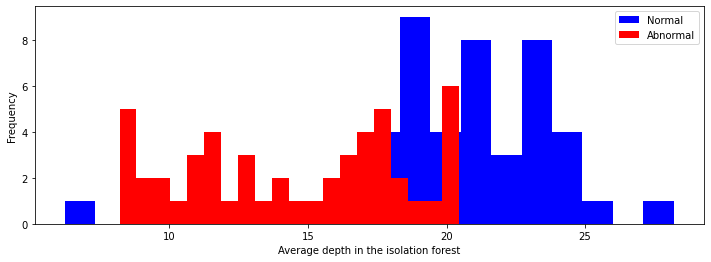

In [34]:
plt.figure(figsize=(12,4))
plt.hist(normal_depths, label='Normal', bins=20, density=False, color='blue')
plt.hist(abnormal_depths, label='Abnormal', bins=20, density=False, color='red')
plt.xlabel('Average depth in the isolation forest')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In this histogram, we can see that there exists a tendency for which the average depth for abnormal is smaller than the normal items, which is what we observed in part 2.2. Following this, the maximum average depth for normal is much larger than the abnormal, and the minimum average depth for abnormal is much smaller than the normal.


Also, we have to consider that these computations are based on randomness. Therefore, every time we will see different results (although with the same tendencies).

## 3.2. Compute outlier scores and conclude

In [35]:
# Source: https://stackoverflow.com/a/27683292/1235784

from numpy import euler_gamma
from scipy.special import digamma
def harmonic(s):
    return digamma(s + 1) + euler_gamma

In [36]:
def outlier_score_factory():
    n = len(df.index)
    c_n = 2.0 * harmonic(n - 1.0) - (2.0 * (n-1)/n)
    return lambda d: 2.0**(-d/c_n)

outlier_score = outlier_score_factory()

normal_scores = [outlier_score(d) for d in normal_depths]
abnormal_scores = [outlier_score(d) for d in abnormal_depths]

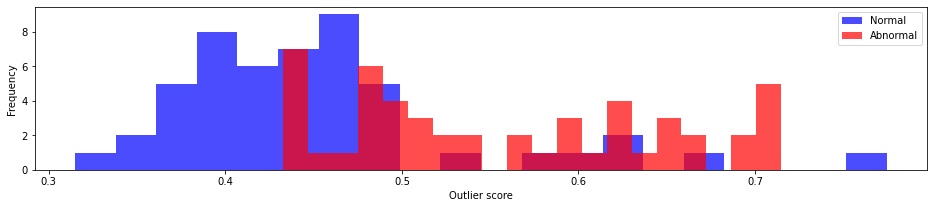

In [37]:
plt.figure(figsize=(16,3))

# Plot the two histograms; the parameter 'alpha' is the transparency of the bar
plt.hist(normal_scores, label='Normal', bins=20, density=False, color='blue', alpha=0.7)
plt.hist(abnormal_scores, label='Abnormal', bins=20, density=False, color='red', alpha=0.7)

# Draw the axis labels, legend, and display
plt.xlabel('Outlier score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In this histogram, we can observe that the abnormal items have a tendency to have a larger outlier score than the normal ones, which are shifted to the left (values closer to 0.0).

We shall reduce the number of abnormals identified as normals (false positives)

Normals identified as normals 36
Normals identified as abnormals 14
Abnormals identified as normals: 8
Abnormals identified as abnormals 42


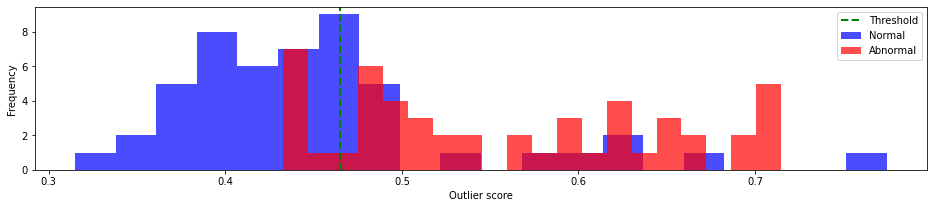

In [38]:
thresh = 0.465 # This value was set under a try/error method

count_normal_in_normal = 0
count_abnormal_in_normal = 0

count_normal_in_abnormal = 0
count_abnormal_in_abnormal = 0

# We count how many scores are above the threshold, and how many are below
for sc in normal_scores:
    if sc <= thresh:
        count_normal_in_normal += 1
    else:
        count_abnormal_in_normal += 1

for sc in abnormal_scores:
    if sc <= thresh:
        count_normal_in_abnormal += 1
    else:
        count_abnormal_in_abnormal += 1

print("We shall reduce the number of abnormals identified as normals (false positives)\n")
print(f"Normals identified as normals {count_normal_in_normal}")
print(f"Normals identified as abnormals {count_abnormal_in_normal}")
print('\033[1m' + f"Abnormals identified as normals: {count_normal_in_abnormal}" + '\033[0m')
print(f"Abnormals identified as abnormals {count_abnormal_in_abnormal}")

plt.figure(figsize=(16,3))

# Plot the two histograms; the parameter 'alpha' is the transparency of the bar
plt.hist(normal_scores, label='Normal', bins=20, density=False, color='blue', alpha=0.7)
plt.hist(abnormal_scores, label='Abnormal', bins=20, density=False, color='red', alpha=0.7)

# Draw the axis labels, legend, and display
plt.axvline(x=thresh, color='g', linestyle='dashed', linewidth=2, label = "Threshold")
plt.xlabel('Outlier score')
plt.ylabel('Frequency')
plt.legend()
plt.show()



The optimal threshold was set under the aim of reducing the amount of false positives to the minimum. Since identifying as positive something that is negative could turn into complications (for instance, in medically related issues, if some ill person is identified as healthy very bad for they), we have to reduce this value as much as we can. Also, the ratio between correctly-identified items and non correctly-identified items is satisfactory.


Therefore, the variable "thresh" (the optimal threshold) was set by trial/error, trying to reduce as much as possible this condition. The value **0.475** always gave a very reasonable number amount for each condition. 